# Meteo idiote

## Introduction
C'est un peu mon ML100
Comment utiliser l'exemple le plus idiot permet tout de même d'apprendre les réseaux de neurones. 

*Quel est le principe et pourquoi c'est idiot ?*
Le principe est de déduire la saison en indiquant la température.
C'est évident, la techno/solution est mal adaptée, le degré d'incertitude est énorme.
L'efficacité sera proche de l'aléatoire.
Bref, c'est inutile!

*Pourquoi c'est tout de même intéressant ?*
Pour apprendre
* Trouver les données (datasets)
* Nettoyer les données et les préparer (data cleaning et data prep)
* Préparation de l'environnement (Environment setup, Python virtualenv/pyenv/conda headache) et ainsi apprendre et raffraîchir ses connaissances 
* Construire le modèle (Keras model)
* Le sauvegarder et le réutiliser
* prédire


TODO : 
* compléter les analyses de données
* faire une repréentation en 3D avec matplotlib
* mélanger les données
* avoir un jeu de test
* /!\ jouer avec les fonctions d'object 
* récupérer les données avec les heures de mesures (ce qui devrait faire bondir les performances) 
* Une application PWA avec le modèle chargé en local pour l'utiliser à tout moment (tensorflow.js ?)
* utiliser les services en ligne GCP
* S'attaquer à vrai problème utile

## Analyser les données

In [58]:
import numpy as np
from numpy import genfromtxt
from numpy import hsplit
my_data = genfromtxt('iadata.csv', delimiter=';', dtype="f4,u4,S8", names=True)
(temp,hour,label)=my_data['t'],my_data['h'],my_data['season']
print ("temp",temp)
print ("hour",hour)

temp [278.55 277.35 276.85 ... 281.05 282.35 282.55]
hour [     0      0      0 ... 210000 210000 210000]


In [66]:
from numpy import stack
feature=stack((temp,hour),axis=1)
feature

array([[   278.54998779,      0.        ],
       [   277.3500061 ,      0.        ],
       [   276.8500061 ,      0.        ],
       ...,
       [   281.04998779, 210000.        ],
       [   282.3500061 , 210000.        ],
       [   282.54998779, 210000.        ]])

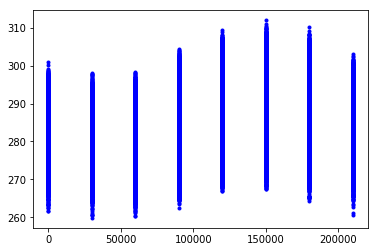

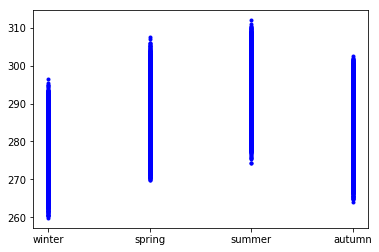

In [73]:
import matplotlib.pyplot as plt
my_rec = my_data.view(np.recarray)
plt.plot(my_rec.h,my_rec.t,'b.')
#plt.ylim (0.,210000)
plt.show()

plt.plot(my_rec.season,my_rec.t,'b.')
plt.show()

Les données montrent que le modèle ne sera pas pertinent entre 275°K (2°c) et 295°C (22°C).
On s'en doutait...

## Préparation des données

In [75]:
from keras import models
from keras import layers

feature = feature.reshape((161449,2))
feature = feature.astype('float32')

feature.ndim

2

In [76]:
feature

array([[   278.55,      0.  ],
       [   277.35,      0.  ],
       [   276.85,      0.  ],
       ...,
       [   281.05, 210000.  ],
       [   282.35, 210000.  ],
       [   282.55, 210000.  ]], dtype=float32)

In [78]:
from numpy import average
average(feature.T[0])

284.42477

In [79]:
label

array([b'winter', b'winter', b'winter', ..., b'winter', b'winter',
       b'winter'], dtype='|S8')

In [80]:
label.ndim

1

## Transformer les variables de sortie (les saisons) en vecteur de probabilité de saison

In [82]:
len(label)
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
transformed_label = encoder.fit_transform(label)
print(transformed_label)

[[0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]


In [83]:
#from keras.preprocessing.text import Tokenizer
#tokenizer = Tokenizer(char_level=True)
#tokenizer.fit_on_texts(label)
#sequence_of_int = tokenizer.texts_to_sequences(label)
#print (sequence_of_int)
#from keras.utils import to_categorical
#new_label= to_categorical(label, num_classes=4, dtype='int32')
#new_label= to_categorical(label, num_classes=4)
#print (new_label)

In [84]:

transformed_label[6819]

array([0, 0, 1, 0])

## Construction du réseau de neurone et compilation

In [86]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu',input_dim = 2))
network.add(layers.Dense(4, activation='softmax'))
#definition de la fonction de perte et de l'algo d'optim
network.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])


## Entrainement et évaluation de l'entrainement

TODO : séparer les variables d'entrainbement et de contrôle du modèle (il doit y avoir une fonction pour ça)

In [89]:
network.fit(feature, transformed_label,epochs=5, batch_size=128)

test_loss, test_acc = network.evaluate(feature, transformed_label)
print ('test_acc:', test_acc)

Epoch 1/5
161449/161449 [==============================] - 8s 48us/step - loss: 12.0806 - acc: 0.2505
Epoch 2/5
161449/161449 [==============================] - 7s 46us/step - loss: 12.0805 - acc: 0.2505
Epoch 3/5
161449/161449 [==============================] - 7s 46us/step - loss: 12.0805 - acc: 0.2505
Epoch 4/5
161449/161449 [==============================] - 7s 46us/step - loss: 12.0805 - acc: 0.2505
Epoch 5/5
161449/161449 [==============================] - 4s 24us/step
test_acc: 0.2505001579446141


## Prédiction d'été à midi 32°C

In [100]:
prediction = network.predict(np.array([[32.+273.15, 120000.]]))
print(prediction)

[[1. 0. 0. 0.]]


## Prédiction d'hiver à minuit -5°C

In [99]:
prediction = network.predict(np.array([[273.15-5, 0.]]))
print(prediction)

[[9.7258812e-10 1.0000000e+00 1.3495114e-17 6.3496447e-10]]


ça bug là...

In [24]:
from keras.models import model_from_json
import os

In [21]:
# serialize model to JSON
model_json = network.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
network.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [25]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [27]:
prediction = loaded_model.predict(np.array([273.15-10]))
print(prediction)

[[6.8442406e-17 1.0000000e+00 5.6438913e-11 8.3561097e-16]]


## The end